<a href="https://colab.research.google.com/github/ychervonyi/reinforcement-learning-learning/blob/main/racetrack_monte_carlo_chapter5_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from collections import Counter
from matplotlib import pyplot
from tqdm import tqdm

np.random.seed(1231231)


class Point:
    def __init__(self, rr, cc):
        self.y = rr
        self.x = cc


def collinear(p1, p2, p3):
    """
    Return true iff p1, p2, and p3 all lie on the same line.
    """
    return (p2.x - p1.x) * (p3.y - p1.y) == (p3.x - p1.x) * (p2.y - p1.y)


def within(a, b, c):
    """
    Return true iff b is between a and c (inclusive).
    """
    return a <= b <= c or c <= b <= a


class Segment:
    def __init__(self, p1, p2):
        self.p1 = p1
        self.p2 = p2
        self.A = p2.y - p1.y
        self.B = p1.x - p2.x
        self.C = self.A * p1.x + self.B * p1.y

    def print(self):
        print(f"x1: {self.p1.x}, y1: {self.p1.y}")
        print(f"x2: {self.p2.x}, y2: {self.p2.y}")

    def p_is_on(self, p):
        return (collinear(self.p1, self.p2, p)
                and (within(self.p1.x, p.x, self.p2.x) if self.p1.x != self.p2.x else
                     within(self.p1.y, p.y, self.p2.y)))


def segments_intersect(s1, s2):
    A1, B1, C1 = s1.A, s1.B, s1.C
    A2, B2, C2 = s2.A, s2.B, s2.C
    det = A1 * B2 - A2 * B1
    if det == 0:
        return False
    x = (B2 * C1 - B1 * C2) / det
    y = (A1 * C2 - A2 * C1) / det

    for s in (s1, s2):
        x1, x2 = s.p1.x, s.p2.x
        y1, y2 = s.p1.y, s.p2.y
        if not (min(x1, x2) <= x <= max(x1, x2) and min(y1, y2) <= y <= max(y1, y2)):
            return False
    return True


def compare_points(p1, p2):
    return p1.x == p2.x and p1.y == p2.y


def compare_segments(s1, s2):
    return compare_points(s1.p1, s2.p1) and compare_points(s1.p2, s2.p2)


class Environment:
    def __init__(self):
        self.build()

    def build(self):
        # NOTE: this is an ugly way to define the track geometry
        # Here we define the track as a polygon
        rows = 30
        cols = 15

        self.max_v, self.min_v = 5, 0
        self.rows, self.cols = rows, cols
        self.state_tuple = (rows, cols, self.max_v, self.max_v)

        self.start_segment = Segment(Point(0, 0), Point(0, 10))
        print("Start line:")
        self.start_segment.print()
        self.finish_segment = Segment(Point(10, 15), Point(30, 15))
        print("Finish line:")
        self.finish_segment.print()

        # Define start points
        self.start_points = []
        r = 0
        for c in range(1, 10):
            self.start_points.append((r, c))

        # Boundaries
        points = [
            Point(0, 0),
            Point(0, 10),
            Point(10, 10),
            Point(10, 15),
            Point(30, 15),
            Point(30, 0)
        ]

        # Bounds should not have start and finish lines
        self.bounds = []
        for i in range(1, len(points)):
            s = Segment(points[i - 1], points[i])
            if compare_segments(s, self.finish_segment) or compare_segments(s, self.start_segment):
                continue
            print(f"Adding boundary...")
            s.print()
            self.bounds.append(s)

        self.bounds.append(Segment(points[-1], points[0]))
        print(f"Adding boundary...")
        self.bounds[-1].print()

        self.build_all_actions()

    def build_all_actions(self):
        dv = [-1, 0, 1]
        n_dv = len(dv)
        self.all_actions_map = {}
        self.all_actions = []
        for i, d_vr in enumerate(dv):
            for j, d_vc in enumerate(dv):
                self.all_actions.append((d_vr, d_vc))
                self.all_actions_map[f"{d_vr}_{d_vc}"] = i * n_dv + j
        self.n_actions = len(self.all_actions)

    def is_good_velocity(self, vr_, vc_):
        if (vr_, vc_) == (
        self.min_v, self.min_v) or vr_ < self.min_v or vr_ >= self.max_v or vc_ < self.min_v or vc_ >= self.max_v:
            return False
        return True

    def get_possible_action_indices(self, vr_, vc_):
        """
        Get possible actions for current velocity `vr_, vc_`.
        """
        # 9 actions for each state - increase, decrease or
        # don't change velocity components

        possible_actions_indicies = []
        for d_vr, d_vc in self.all_actions:
            if self.is_good_velocity(vr_ + d_vr, vc_ + d_vc):
                possible_actions_indicies.append(self.all_actions_map[f"{d_vr}_{d_vc}"])
        return possible_actions_indicies

    def get_episode(self, policy_fn):
        """
        Generate an episode.
        """
        hits = 0
        reward = -1
        vr = vc = 0
        r, c = self.start_points[np.random.randint(0, len(self.start_points))]
        finish = False
        history = []
        while not finish:
            d_vr, d_vc, prob = policy_fn(r, c, vr, vc)
            new_vr, new_vc = vr + d_vr, vc + d_vc

            assert not (new_vr == 0 and new_vc == 0 and (r, c) in self.start_points), f"{new_vr} {new_vc} {r} {c}"

            # Check if the new path intersects finish line
            # If yes we are done with this episode
            new_path = Segment(Point(r, c), Point(r + new_vr, c + new_vc))
            if segments_intersect(self.finish_segment, new_path):
                history.append((r, c, vr, vc, d_vr, d_vc, 0, prob))
                break

            # Check if the path intersects boundaries
            # If yes we move the car to the start line
            hit = False
            for bound in self.bounds:
                if segments_intersect(bound, new_path):
                    hit = True
                    # TODO: Worse reward for hitting a boundary?
                    history.append((r, c, vr, vc, d_vr, d_vc, -5, prob))
                    hits += 1
                    r, c = self.start_points[np.random.randint(0, len(self.start_points))]
                    vr = vc = 0

            # Update velocity and position if didn't hit a bound
            if not hit:
                history.append((r, c, vr, vc, d_vr, d_vc, -1, prob))
                vr, vc = new_vr, new_vc
                r += vr
                c += vc
        return history, hits

    def plot_episode(self, history):
        track = np.zeros((self.rows, self.cols))
        pyplot.imshow(track)
        for item in history:
            # r, c, vr, vc, d_vr, d_vc, reward, p = item
            pyplot.plot(item[1], item[0], '.r')
        pyplot.show()

    def print_episode(self, history):
        """
        Follow `history` and print how many times in history
        each cell was visited.
        """
        track = np.zeros((self.rows, self.cols))
        for item in history:
            # r, c, vr, vc, d_vr, d_vc, reward, p = item
            track[item[0], item[1]] += 1
        return track.astype("int")

In [2]:
class Agent:
    def __init__(self, env, epsilon=0.1):
        self.env = env
        # Value function
        self.Q = np.random.uniform(
            low=0,
            high=self.env.n_actions,
            size=self.env.state_tuple + (self.env.n_actions,)
        )
        # self.Q = np.zeros(self.env.state_tuple + (self.env.n_actions,))

        # Cumulative sum of weights
        self.C = np.zeros(self.env.state_tuple + (self.env.n_actions,))
        # Policy
        # self.policy = np.argmax(Q, axis=4)
        # self.policy = np.zeros((rows, cols))
        self.policy_init_value = -1
        self.policy = np.full(self.env.state_tuple, self.policy_init_value)

        self.epsilon = epsilon

    def random_policy(self, r, c, vr, vc):
        possible_action_indices = self.env.get_possible_action_indices(vr, vc)
        assert not len(possible_action_indices) == 0, f"No possible actions for {r, c, vr, vc}"
        prob = 1 / len(possible_action_indices)
        a_index = np.random.choice(possible_action_indices)
        return self.env.all_actions[a_index] + (prob, )

    def soft_greedy_policy(self, r, c, vr, vc):
        possible_action_indices = self.env.get_possible_action_indices(vr, vc)
        assert not len(possible_action_indices) == 0, f"No possible actions for {r, c, vr, vc}"
        prob = 1 / len(possible_action_indices)

        if np.random.rand() > self.epsilon and self.policy[r, c, vr, vc] in possible_action_indices:
            a_index = self.policy[r, c, vr, vc]
        else:
            a_index = np.random.choice(possible_action_indices)
        return self.env.all_actions[a_index] + (prob, )

    def greedy_policy(self, r, c, vr, vc):
        possible_action_indices = self.env.get_possible_action_indices(vr, vc)
        assert not len(possible_action_indices) == 0, f"No possible actions for {r, c, vr, vc}"
        prob = 1 / len(possible_action_indices)

        if self.policy[r, c, vr, vc] in possible_action_indices:
            a_index = self.policy[r, c, vr, vc]
        else:
            a_index = np.random.choice(possible_action_indices)
        return self.env.all_actions[a_index]+ (prob, )

In [19]:
class MonteCarlo:
    def __init__(self, agent, env):
        self.gamma = 1
        self.agent = agent
        self.env = env
        self.n_elements = self.agent.policy.size

    def learn_episode(self, history):
        """
        Learn from an episode
        """
        G = 0
        W = 1
        for i in range(len(history) - 1, -1, -1):
            r, c, vr, vc, d_vr, d_vc, reward, prob = history[i]
            a_index = self.env.all_actions_map[f"{d_vr}_{d_vc}"]
            G = self.gamma * G + reward
            self.agent.C[r, c, vr, vc, a_index] += W
            self.agent.Q[r, c, vr, vc, a_index] += W / self.agent.C[r, c, vr, vc, a_index] * (
                        G - self.agent.Q[r, c, vr, vc, a_index])
            self.agent.policy[r, c, vr, vc] = np.argmax(self.agent.Q[r, c, vr, vc])

            if self.agent.policy[r, c, vr, vc] != a_index:
                break
            W /= prob

    def optimize(self, n_episodes):
        steps_cnt = []

        for ep in tqdm(range(n_episodes)):
            if ep % 1000 == 0:
                # Fraction of learned parameters in policy
                frac_params = np.count_nonzero(self.agent.policy != self.agent.policy_init_value) / self.n_elements
                print(f"Episode: {ep},  policy: {round(frac_params * 100, 2)}%")
            hist, hits = self.env.get_episode(self.agent.random_policy)
            steps_cnt.append(len(hist))
            self.learn_episode(hist)

In [20]:
env = Environment()
agent = Agent(env)
mc = MonteCarlo(agent, env)

Start line:
x1: 0, y1: 0
x2: 10, y2: 0
Finish line:
x1: 15, y1: 10
x2: 15, y2: 30
Adding boundary...
x1: 10, y1: 0
x2: 10, y2: 10
Adding boundary...
x1: 10, y1: 10
x2: 15, y2: 10
Adding boundary...
x1: 15, y1: 30
x2: 0, y2: 30
Adding boundary...
x1: 0, y1: 30
x2: 0, y2: 0


In [21]:
mc.optimize(20000)

  1%|          | 147/20000 [00:00<00:29, 664.14it/s]

Episode: 0,  policy: 0.0%


  6%|▌         | 1229/20000 [00:01<00:24, 769.90it/s]

Episode: 1000,  policy: 4.39%


 11%|█         | 2158/20000 [00:02<00:22, 793.28it/s]

Episode: 2000,  policy: 5.82%


 16%|█▌        | 3167/20000 [00:04<00:20, 834.84it/s]

Episode: 3000,  policy: 6.49%


 21%|██        | 4222/20000 [00:05<00:19, 829.66it/s]

Episode: 4000,  policy: 6.84%


 26%|██▌       | 5118/20000 [00:06<00:19, 779.21it/s]

Episode: 5000,  policy: 7.16%


 31%|███       | 6155/20000 [00:07<00:19, 705.22it/s]

Episode: 6000,  policy: 7.47%


 36%|███▌      | 7201/20000 [00:09<00:16, 781.91it/s]

Episode: 7000,  policy: 7.64%


 41%|████      | 8108/20000 [00:10<00:14, 808.75it/s]

Episode: 8000,  policy: 7.87%


 46%|████▌     | 9199/20000 [00:11<00:13, 778.29it/s]

Episode: 9000,  policy: 8.02%


 51%|█████     | 10218/20000 [00:13<00:13, 707.26it/s]

Episode: 10000,  policy: 8.25%


 55%|█████▌    | 11087/20000 [00:14<00:12, 737.13it/s]

Episode: 11000,  policy: 8.36%


 61%|██████    | 12149/20000 [00:15<00:10, 758.53it/s]

Episode: 12000,  policy: 8.51%


 66%|██████▌   | 13119/20000 [00:17<00:09, 759.62it/s]

Episode: 13000,  policy: 8.6%


 71%|███████   | 14203/20000 [00:18<00:07, 763.69it/s]

Episode: 14000,  policy: 8.76%


 76%|███████▌  | 15139/20000 [00:19<00:05, 819.14it/s]

Episode: 15000,  policy: 8.85%


 81%|████████  | 16203/20000 [00:20<00:04, 779.28it/s]

Episode: 16000,  policy: 8.98%


 86%|████████▌ | 17190/20000 [00:22<00:03, 704.31it/s]

Episode: 17000,  policy: 9.09%


 91%|█████████ | 18216/20000 [00:23<00:02, 807.32it/s]

Episode: 18000,  policy: 9.2%


 96%|█████████▌| 19114/20000 [00:24<00:01, 822.41it/s]

Episode: 19000,  policy: 9.29%


100%|██████████| 20000/20000 [00:26<00:00, 767.53it/s]


Number of steps: 12, number of hits: 0


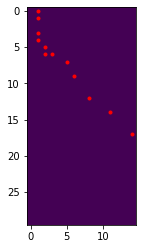

In [26]:
history, hits = env.get_episode(agent.greedy_policy)
print(f"Number of steps: {len(history)}, number of hits: {hits}")
env.plot_episode(history)

Number of steps: 21, number of hits: 0


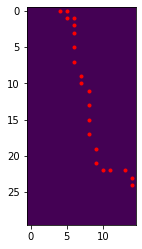

In [28]:
history, hits = env.get_episode(agent.greedy_policy)
print(f"Number of steps: {len(history)}, number of hits: {hits}")
env.plot_episode(history)

Number of steps: 10, number of hits: 0


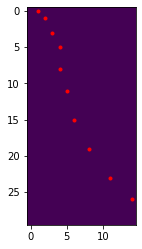

In [33]:
history, hits = env.get_episode(agent.greedy_policy)
print(f"Number of steps: {len(history)}, number of hits: {hits}")
env.plot_episode(history)